# Land Price Estimation (Kozhikode) - Building a Predictive Model

**Goal:** Predict land prices in Kozhikode using real-world CSV data following a systematic ML workflow.

**Pipeline:**  
1. Load Data  
2. Prepare Data & Feature Engineering  
3. Split Train/Test  
4. Train Model  
5. Evaluate Performance  
6. Visualize Results  

In [24]:
# Imports & Setup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 1. Load Data
In this step, we load the dataset and perform a quick first look to understand what we are working with.

In [25]:
csv_file_path = 'data/land_prices.csv'  # Path to CSV file
df = pd.read_csv(csv_file_path)

df.head()

,property_id,location_name,taluk,village,latitude,longitude,land_area_cents,land_type,distance_to_school_km,distance_to_airport_km,distance_to_railway_station_km,distance_to_hospital_km,distance_to_medical_college_km,distance_to_bus_stop_km,distance_to_market_km,price_lakhs
0,1.0,Chevayur,Kozhikode,Chevayur,11.278,75.814,5.5,Residential,0.8,26.5,5.1,1.2,2.5,0.4,1.1,16.5
1,2.0,Medical College Area,Kozhikode,Kozhikode,11.282,75.833,4.0,Commercial,0.5,27.1,6.5,0.3,0.5,0.2,0.8,22.0
2,3.0,Kunnamangalam,Kozhikode,Kunnamangalam,11.319,75.879,10.0,Residential,1.5,25.0,12.0,3.0,5.0,0.8,1.5,25.0
3,4.0,Feroke,Kozhikode,Feroke,11.183,75.833,8.0,Residential,1.2,18.0,7.5,2.5,12.0,0.7,1.8,20.0
4,5.0,Balussery,Koyilandy,Balussery,11.445,75.828,15.0,Agricultural,2.5,38.0,18.0,3.5,20.0,1.2,2.0,18.0


## 02. Prepare Data & Feature Engineering

This step converts raw land data into clean, model-ready predictors.

### Step 2.1: Create **Price per Cent**

Land plots have different sizes, so total price is not directly comparable.  
To make the target fair across all plots, we compute:
$$
\text{Price per Cent} = \frac{\text{Total Price(in Lakhs)}}{\text{Land Area (in Cent)}}
$$
This becomes our main prediction target later.

In [26]:
df["price_per_cent"] = df["price_lakhs"] / df["land_area_cents"]
df[["price_lakhs", "land_area_cents", "price_per_cent"]].head()

,price_lakhs,land_area_cents,price_per_cent
0,16.5,5.5,3.0
1,22.0,4.0,5.5
2,25.0,10.0,2.5
3,20.0,8.0,2.5
4,18.0,15.0,1.2


### Step 2.2: Identify Feature Types & Encode Categorical Data

After creating `price_per_cent`, we prepare the dataset for machine learning.

- Numerical features are kept as they are
- Categorical (text) features cannot be used directly
- Categorical features are converted into numerical form using **one-hot encoding**

In [27]:
df.columns

Index(['property_id', 'location_name', 'taluk', 'village', 'latitude',
       'longitude', 'land_area_cents', 'land_type', 'distance_to_school_km',
       'distance_to_airport_km', 'distance_to_railway_station_km',
       'distance_to_hospital_km', 'distance_to_medical_college_km',
       'distance_to_bus_stop_km', 'distance_to_market_km', 'price_lakhs',
       'price_per_cent'],
      dtype='str')

**Separate Numerical Features**

These columns already contain numeric values and can be used directly by the model.

In [28]:
numeric_features = [
    'land_area_cents',
    'distance_to_school_km',
    'distance_to_airport_km',
    'distance_to_railway_station_km',
    'distance_to_hospital_km',
    'distance_to_medical_college_km',
    'distance_to_bus_stop_km',
    'distance_to_market_km',
]


**Encode Categorical Features**

Text columns such as location, taluk, land_type and village names are converted into numeric form using **one-hot encoding**.


In [29]:
df_processed = pd.get_dummies(
    df,
    columns=['location_name', 'taluk', 'village', 'land_type'],
)

df_processed.head()


,property_id,latitude,longitude,land_area_cents,distance_to_school_km,distance_to_airport_km,distance_to_railway_station_km,distance_to_hospital_km,distance_to_medical_college_km,distance_to_bus_stop_km,...,village_Mavoor,village_Olavanna,village_Pantheerankavu,village_Peruvayal,village_Ramanattukara,village_Thamarassery,village_Vatakara,land_type_Agricultural,land_type_Commercial,land_type_Residential
0,1.0,11.278,75.814,5.5,0.8,26.5,5.1,1.2,2.5,0.4,...,False,False,False,False,False,False,False,False,False,True
1,2.0,11.282,75.833,4.0,0.5,27.1,6.5,0.3,0.5,0.2,...,False,False,False,False,False,False,False,False,True,False
2,3.0,11.319,75.879,10.0,1.5,25.0,12.0,3.0,5.0,0.8,...,False,False,False,False,False,False,False,False,False,True
3,4.0,11.183,75.833,8.0,1.2,18.0,7.5,2.5,12.0,0.7,...,False,False,False,False,False,False,False,False,False,True
4,5.0,11.445,75.828,15.0,2.5,38.0,18.0,3.5,20.0,1.2,...,False,False,False,False,False,False,False,True,False,False


### Step 2.3: Identify Dummy Features

After applying one-hot encoding, categorical columns expand into multiple dummy variables (village_Vatakara, land_type_Agricultural, land_type_Commercial etc.).
This step programmatically collects all encoded categorical features so they can be
handled separately from numerical features in later stages.


In [30]:
# Collect dummy (one-hot encoded) feature names
dummy_features = []

for column_name in df_processed.columns:
    if (
        column_name.startswith('land_type') or
        column_name.startswith('village') or
        column_name.startswith('location_name') or
        column_name.startswith('taluk')
    ):
        dummy_features.append(column_name)

# View all dummy features
dummy_features

['location_name_Balussery',
 'location_name_Beypore',
 'location_name_Chevayur',
 'location_name_Elathur',
 'location_name_Feroke',
 'location_name_Kakkodi',
 'location_name_Karaparamba',
 'location_name_Koduvally',
 'location_name_Koyilandy',
 'location_name_Kunnamangalam',
 'location_name_Mavoor',
 'location_name_Medical College Area',
 'location_name_Olavanna',
 'location_name_Pantheerankavu',
 'location_name_Peruvayal',
 'location_name_Ramanattukara',
 'location_name_Thamarassery',
 'location_name_Vatakara',
 'taluk_Koyilandy',
 'taluk_Kozhikode',
 'taluk_Thamarassery',
 'taluk_Vatakara',
 'village_Balussery',
 'village_Beypore',
 'village_Chevayur',
 'village_Elathur',
 'village_Feroke',
 'village_Kakkodi',
 'village_Karaparamba',
 'village_Koduvally',
 'village_Koyilandy',
 'village_Kozhikode',
 'village_Kunnamangalam',
 'village_Mavoor',
 'village_Olavanna',
 'village_Pantheerankavu',
 'village_Peruvayal',
 'village_Ramanattukara',
 'village_Thamarassery',
 'village_Vatakara',
 

## Step 2.4: Combine Numerical + Dummy Features

We now combine:
- `numeric_features` (continuous values)
- `dummy_features` (one-hot encoded categorical columns)

This creates the final feature set used for training.

In [31]:
final_features = numeric_features + dummy_features

# Create final X and y
X = df_processed[final_features]
y = df_processed["price_per_cent"]

X.head()

,land_area_cents,distance_to_school_km,distance_to_airport_km,distance_to_railway_station_km,distance_to_hospital_km,distance_to_medical_college_km,distance_to_bus_stop_km,distance_to_market_km,location_name_Balussery,location_name_Beypore,...,village_Mavoor,village_Olavanna,village_Pantheerankavu,village_Peruvayal,village_Ramanattukara,village_Thamarassery,village_Vatakara,land_type_Agricultural,land_type_Commercial,land_type_Residential
0,5.5,0.8,26.5,5.1,1.2,2.5,0.4,1.1,False,False,...,False,False,False,False,False,False,False,False,False,True
1,4.0,0.5,27.1,6.5,0.3,0.5,0.2,0.8,False,False,...,False,False,False,False,False,False,False,False,True,False
2,10.0,1.5,25.0,12.0,3.0,5.0,0.8,1.5,False,False,...,False,False,False,False,False,False,False,False,False,True
3,8.0,1.2,18.0,7.5,2.5,12.0,0.7,1.8,False,False,...,False,False,False,False,False,False,False,False,False,True
4,15.0,2.5,38.0,18.0,3.5,20.0,1.2,2.0,True,False,...,False,False,False,False,False,False,False,True,False,False


## Step 3: Split Training & Testing Sets

We split the prepared dataset into:
- **Training set** (used to learn patterns)
- **Testing set** (used to evaluate on unseen data)

This helps measure how well the model generalizes.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (40, 51)
X_test : (10, 51)
y_train: (40,)
y_test : (10,)


## Step 4: Train the Model

In this step, we train a machine learning model using the training data.
A **Random Forest regression model** is used since we are predicting a continuous value (**price per cent**). 

Random Forest is well-suited for this task as it can capture non-linear relationships and complex feature
interactions present in land price data.

In [33]:
# Initialize the model
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
)
# Train the model
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

The model has now learned the relationship between land features and
price per cent using the training dataset.

## Step 5: Model Evaluation

In this step, we evaluate how well the trained model performs on
unseen test data.

We do this by:
1. Comparing actual vs predicted values
2. Computing standard regression evaluation metrics


In [34]:
# Make predictions on test data
y_pred = model.predict(X_test)

**Actual vs Predicted Comparison**

This table helps visually inspect how close the model’s predictions
are to the actual land price per cent values.


In [35]:
df_comparison = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

df_comparison.head()


,Actual,Predicted
13,2.2,2.533
39,1.7,1.636
30,2.1,2.459
45,2.1,2.507
17,5.0,4.404


**Evaluation Metrics**

We use the following metrics:
- **MAE (Mean Absolute Error)**: average prediction error
- **RMSE (Root Mean Squared Error)**: penalizes larger errors


In [36]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

MAE  : 0.4127
RMSE : 0.4787


The model achieved an MAE of 0.4127, indicating that on average the predicted land price per cent differs from the actual value by approximately 0.41 units. This shows a  elatively low average prediction error.

The RMSE value of 0.4787 is slightly higher than the MAE, suggesting that while most predictions are accurate, a few larger errors exist and are
penalized more heavily by RMSE. Overall, the close values of MAE and RMSE indicate stable and consistent model performance on the test data.

## Step 6: Visualization

Visualization helps us visually evaluate how well the model performs.

We use:
- Actual vs Predicted plot
- Residuals plot

These plots show prediction accuracy and error patterns.


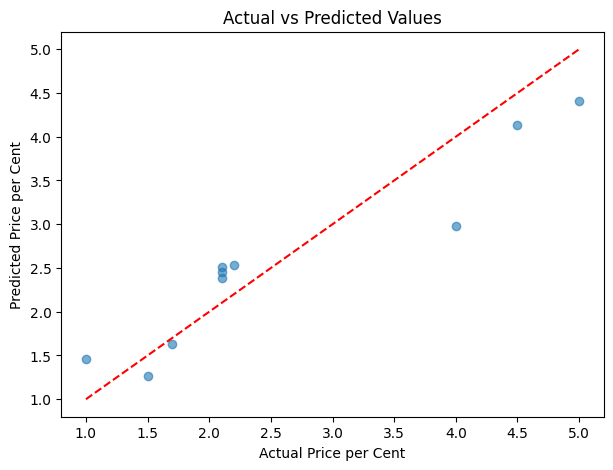

In [37]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)

# Diagonal reference line (perfect prediction) [y=x]
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual Price per Cent")
plt.ylabel("Predicted Price per Cent")
plt.title("Actual vs Predicted Values")
plt.show()

**Residual Plot**

Residuals represent the difference between actual and predicted values.
A good model shows residuals randomly scattered around zero.


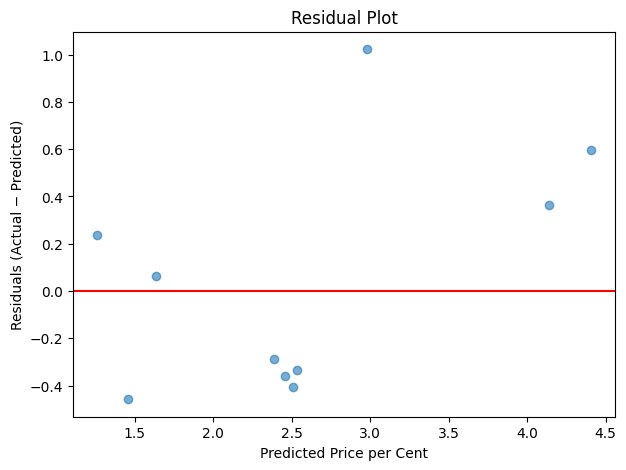

In [38]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Predicted Price per Cent")
plt.ylabel("Residuals (Actual − Predicted)")
plt.title("Residual Plot")
plt.show()


**Visualization Completed**

The plots indicate how well the Random Forest model predicts land
price per cent and whether systematic errors are present.


___

## Prediction on New Data

After training and evaluating the model, we use it to predict the **price per cent** for a new, unseen land plot.

This step demonstrates how the trained model can be used in practice.

In [39]:
# Create empty input with all features = 0
new_data = pd.DataFrame([dict.fromkeys(model.feature_names_in_, 0)])

new_data.head()

,land_area_cents,distance_to_school_km,distance_to_airport_km,distance_to_railway_station_km,distance_to_hospital_km,distance_to_medical_college_km,distance_to_bus_stop_km,distance_to_market_km,location_name_Balussery,location_name_Beypore,...,village_Mavoor,village_Olavanna,village_Pantheerankavu,village_Peruvayal,village_Ramanattukara,village_Thamarassery,village_Vatakara,land_type_Agricultural,land_type_Commercial,land_type_Residential
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
new_data['land_area_cents'] = 10
new_data['distance_to_school_km'] = 1.2
new_data['distance_to_airport_km'] = 18
new_data['distance_to_railway_station_km'] = 5
new_data['distance_to_hospital_km'] = 2
new_data['distance_to_medical_college_km'] = 6
new_data['distance_to_bus_stop_km'] = 0.5
new_data['distance_to_market_km'] = 1.0

# categorical selections
new_data['location_name_Beypore'] = 1
new_data['taluk_Kozhikode'] = 1
new_data['village_Beypore'] = 1
new_data['land_type_Residential'] = 1

new_data.head()

,land_area_cents,distance_to_school_km,distance_to_airport_km,distance_to_railway_station_km,distance_to_hospital_km,distance_to_medical_college_km,distance_to_bus_stop_km,distance_to_market_km,location_name_Balussery,location_name_Beypore,...,village_Mavoor,village_Olavanna,village_Pantheerankavu,village_Peruvayal,village_Ramanattukara,village_Thamarassery,village_Vatakara,land_type_Agricultural,land_type_Commercial,land_type_Residential
0,10,1.2,18,5,2,6,0.5,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [41]:
#Predict price per cent for the new data point
predicted_price_per_cent = model.predict(new_data)
print(f"Predicted Price per Cent: {predicted_price_per_cent}")

Predicted Price per Cent: [2.752]
